# Exercise 5C - Working with EnergyPlus and Python

Introduced in Tutorial 5

The purpose of this exercise is to show you how EnergyPlus simulations can be automated with Python. We will learn how to launch EnergyPlus through a command line prompt, modify the EnergyPlus input file (idf), and automate the generation of different iterations of that file. These lessons form the basis for the EnergyPlus scripts we will use in the second half of the course.

### Colour codes

<span style="color:orange;"> Orange text is for emphasis and definitions </span>

<span style="color:lime;"> Green text is for tasks to be completed by the student </span>

<span style="color:dodgerblue;"> Blue text is for Python coding tricks and references </span>

## Load all the necessary Python packages
All packages should work with Conda environment if installed on your machine. Otherwise all necessary packages can be installed in a virtual environment (.venv) in VS Code using: Ctrl+Shift+P > Python: Create Environment > Venv > Python 3.12.x > requirements.txt

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import subprocess
import time

## 1. Getting Started
### 1.1 Enter the general parameters for this run.

<span style="color:limegreen;"> This cell contains editable options for running EnergyPlus in this course. Please familiarise yourself with them and what they mean. You should not have to change any of them for this Exercise_5C, but may need to change them in the future.</span>

* **saveName**: Append this to any results file or images. You will want to edit to change these for each unique run and notebook.
* **ep_dir**: This is the directory the EnergyPlus executable is in. Select the correct format depending on whether you use Windows or Mac/Linux. The path may be different depending on whether you chose to install EnergyPlus. 
    * <span style="color:orange;">NOTE: Enter the path to the directory using the Pathlib.Path format as shown. This helps to avoid any cross-platform compatibility issues. Enter each sub-directory as a tuple separated by commas. Note the special characters required for drive letters. </span>
* **weatherFile**: The epw format weather file which will be used in the simulation. These need to be located in the *src/weatherData/* directory
* **idf_file**: The energyPlus input file in idf format. These need to be located in the */idfs/* directory
* **parameters_file**: This is a json file which tells us the range of values we want to use for each parameter in a batch simulation. These need to be located in the */simulationParameters/* directory. We will not be using these until Tutorial 6.
* **n_simulations**: The maximum number of simulations to run. I have set to None for this example.


In [2]:
# Enter a save name for this run
saveName = "Exercise_5C"

# Enter the path to the directory with your EnergyPlus executable. Enter the full path separated by commas.
#NOTE: Need to use Pathlib:Path to enter the absolute path to avoid issues cross-platform compatibility issues.
#NOTE: Enter each sub-directory as a tuple separated by commas. Note special characters required for drive letters

ep_dir = Path("/Applications/EnergyPlus-25-1-0") # Example for Linux and Mac


# The weather file to be used for this batch of simulations. This file should be located in the src/weatherData/ directory.
weatherFile = "GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw"

# The baseline file to be used for this simulation. This file should be located in the idfs/ directory
idf_file = "1-storey_Example5C.idf"

# The parameters file to be used as part of this simulation
parameters_file = "Exercise 5C.json"

# The maximum number of simulations to be run
n_simulations = None


This step creates the full paths for the energyPlus directory, idf file, and weather file and confirms they all exist. Else an exception will be created.

In [3]:
idf_path = Path("idfs", idf_file)
weather_file_path = Path("weatherData", weatherFile)

if not ep_dir.exists():
    raise Exception (f"Could not find energyPlus executable at {ep_dir}.")
if not idf_path.exists():
    raise Exception (f"Could not find idf_file at {idf_path}.")
if not weather_file_path.exists():
    raise Exception (f"Could not find weather_file at {weather_file_path}.")

print (f"The EnergyPlus directory is: {ep_dir}.")
print (f"The baseline idf file is: {idf_path}.")
print (f"The weather file is: {weather_file_path}.")

The EnergyPlus directory is: /Applications/EnergyPlus-25-1-0.
The baseline idf file is: idfs/1-storey_Example5C.idf.
The weather file is: weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw.


### 1.2 IDF Files

EnergyPlus IDF files are plain-text files which contain all the data describing the building (HVAC, geometry, schedules, material properties etc.). These can be created and edited manually in any text editor, through EnergyPlus' IDF editor, or through a third-party tool such as OpenStudio or Design Builder. We can also edit them programmatically as will be demonstrated.

The IDF's we will be using are in the IDF directory. You can open them in VS Code to see how they are structured.

The current files in that directory are:

In [4]:
for f in Path("idfs").glob("*.idf"):
    print (f)


idfs/1-storey_baseline.idf
idfs/1-storey_Example5C.idf


### 1.3 Weather Files

EnergyPlus requires detailed weather data to run a simulation. The weather data is in the epw file format and contains hourly (or sub-hourly) weather data which includes temperature, humidity, radiation, illumination, wind velocity data and more. The epw format is standardised. Its structure consists of a header which includes metadata about the location (latitude, longitude, timezone, etc.) and tabular weather data.

The epw files are located in the weatherData directory. You can open them in VS Code or a spreadsheet to see how they are structured. The tabular data contains no headers so it is not clear what columns are what but an expalnation can be found here: [EPW Data Dictionary](https://bigladdersoftware.com/epx/docs/8-3/auxiliary-programs/energyplus-weather-file-epw-data-dictionary.html)

You will need to download some weather files as part of your coursework. They can be found here [EnergyPlus](https://energyplus.net/weather) or here [Climate One](https://climate.onebuilding.org/)

The current files in that directory are:


In [5]:
for f in Path("weatherData").glob("*.epw"):
    print (f)

weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw
weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2004-2018.epw


## 2. Running EnergyPlus through the command line

First begin by creating a new directory within the iterations folder called Exercise_5C.

In [6]:
# Create the folder which the simulation will run in
output_path = Path("iterations", "Exercise_5C")
Path.mkdir(output_path, exist_ok = True)

### 2.1 Generating the command

Most software can be run through Python if we know the command to give. Usually this begins with the executable (.exe) and is followed by a series arguments and optional switches.

The command for EnergyPlus that we will be using is:

ep_cmd = "{ep_path} {idf_path} -w {weather_file_path} -d {output_path}"

* ep_path : The absolute path to the EnergyPlus executable file 
* idf_path : The absolute or relative path to the idf file being simulated
Optional arguments
* -w {weather_file_path} : Indicates we want to use a specific weather file
* -d {output_path}: Indicated we want the output to be stored in a specific directory

In a Jupyter Notebook the EnergyPlus simulation will run silently, ie a window should not appear which shows that the simulation is running. You can also open your Task Manager/Activity Monitor and EnergyPlus task should appear briefly.

In [8]:
# Prepare the EnergyPlus command for Windows (NT) or Mac/Linux (Posix)
if os.name == "nt": # Command for Windows users
    ep_path = Path (ep_dir, "energyplus.exe")
    ep_cmd = f"{ep_path} {idf_path} -w {weather_file_path} -d {output_path}"

# If using a Mac/Linux machine
elif os.name == "posix": # Generate command for Mac/Linux Users
    ep_path = Path (ep_dir, "energyplus")
    ep_cmd = f"/{ep_path} {idf_path} -w {weather_file_path} -d {output_path}"


# Run the simulation through a command line call.
# If EnergyPlus has a return code of 0, the simulation completed successfully
# Otherwise an error occurred and this will be flagged.
print (f"Beginning EnergyPlus simulation.", flush = True)
t0 = time.time()
retcode = subprocess.run(ep_cmd, shell = True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT) 
t1 = time.time()

if retcode.returncode == 0:
    print (f"Finished EnergyPlus simulation. Time of simulation = {t1 - t0:.4f} s.", flush = True)
else:
    print (f"Error in EnergyPlus simulation", flush = True)



Beginning EnergyPlus simulation.
Finished EnergyPlus simulation. Time of simulation = 2.3387 s.


If everything went successfully, you will be able to see some results files appear in the *iterations//Exercise_5C* directory

### 2.2 Results Files

EnergyPlus allows users to output a wide range of results depending on what information the user wants. These EnergyPlus files are set up to output metrics related to energy consumption and overheating/occupant comfort.

There are two results files that are generated:
* eplusout.csv : which contains hourly energy consumption and temperature and relative humidity
* eplustbl.csv : which contains thermal resilience metrics

### 2.2.1 Hourly Results CSV
Open the hourly results csv

In [10]:
# File Path for the eplusout.csv
filePath = Path("/Users/hlbao/Desktop/benv0166/BENV0166_2025/iterations/Exercise_5C/eplusout.csv")

df = pd.read_csv(filePath)
# Convert EnergyPlus' timestamps into a standardized datetime object 
# Need to include the .str.strip() to remove all leading whitespace otherwise an error can occur.
df["Date/Time"] = pd.to_datetime(df["Date/Time"].str.strip(), format = "%Y-%m-%dT%H:%M:%S")
df.set_index("Date/Time", inplace=True)

print ("The hourly outputs in this simulation are:")
for col in df.columns:
    print (f"\t* {col}")

The hourly outputs in this simulation are:
	* Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)
	* LIGHTING_ZONE 1:Lights Electricity Energy [J](Hourly)
	* ELECTRICEQUIPMENT_ZONE 1:Electric Equipment Electricity Energy [J](Hourly)
	* ZONE 1:Zone Operative Temperature [C](Hourly)
	* ZONE 1:Zone Air Temperature [C](Hourly)
	* ZONE 1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Supply Air Total Heating Energy [J](Hourly)
	* ZONE 1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Supply Air Total Cooling Energy [J](Hourly)
	* WATER HEATER:Water Heater Heating Energy [J](Hourly)
	* PEOPLE_ZONE 1:Zone Thermal Comfort Pierce Model Discomfort Index [](Hourly)
	* PEOPLE_ZONE 1:Zone Thermal Comfort Pierce Model Standard Effective Temperature [C](Hourly)
	* Facility:Facility Thermal Comfort ASHRAE 55 Simple Model Summer Clothes Not Comfortable Time [hr](Hourly)
	* ZONE 1:Zone Cooling Setpoint Not Met Time [hr](Hourly)
	* ZONE 1:Zone Heat Index [C](Hourly)
	* ZONE 1:Zone Humidity Index [](Hourly)


Notice that EnergyPlus includes the units and time period of each output. EnergyPlus outputs in base SI units <span style = "color:orange;"> which should be converted to more appropriate units when presenting your results.</span>

We can perform a number of analysis on each column using *Pandas*. Here are some examples:

In [11]:
# Getting the annual sum
heatingSum = df["ZONE 1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Supply Air Total Heating Energy [J](Hourly)"].sum()          # Annual heating demand [J]

# Getting the peak heating load. Why am I dividing this by 3600?
heatingMax = df["ZONE 1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Supply Air Total Heating Energy [J](Hourly)"].max() / 3600   # Peak heating demand [W] 

# Getting counts
hoursTemperatureGreater25C = df["ZONE 1:Zone Operative Temperature [C](Hourly)"][df["ZONE 1:Zone Operative Temperature [C](Hourly)"] > 25].count() # Hours indoor temperature was greater than 25C [h]

# Get monthly sums using resampling
monthlyHeatingSum = df.resample(rule ='ME')["ZONE 1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Supply Air Total Heating Energy [J](Hourly)"].sum()

print (f"The annual heating energy load is {heatingSum:.4f} J.")
print (f"The peak heating load is {heatingMax:.4f} W.")
print (f"The nummber of hours the Temperature is greater than 25\N{DEGREE SIGN}C is {hoursTemperatureGreater25C} hours.")
print (f"The monthly heating energy loads are {monthlyHeatingSum}")

The annual heating energy load is 20741450544.9604 J.
The peak heating load is 5033.3928 W.
The nummber of hours the Temperature is greater than 25°C is 1423 hours.
The monthly heating energy loads are Date/Time
2025-01-31    5.386109e+09
2025-02-28    3.563197e+09
2025-03-31    2.065421e+09
2025-04-30    5.145007e+08
2025-05-31    1.680698e+07
2025-06-30    3.298634e+06
2025-07-31    7.707118e+05
2025-08-31    1.551692e+06
2025-09-30    6.468042e+06
2025-10-31    2.651953e+08
2025-11-30    3.153113e+09
2025-12-31    5.765018e+09
Freq: ME, Name: ZONE 1 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Supply Air Total Heating Energy [J](Hourly), dtype: float64


You can calculate statistics for the other columns in similar manners using Pandas.

I have created a separate function *processHourlyResults* which returns the most useful statistics in a dictionary. You can use that function instead of re-writing the code everytime.
Refer to that function for the units.

In [12]:
# Import the function from src/processResults
from src.processResults import processHourlyResults

# Obtain the results in a dictionary format and then print the results
hourlyResults = processHourlyResults (filePath)

for k, v in hourlyResults.items():
    print (f"{k} : {v}")

heatingSum : 20741450544.96043
heatingMax : 5033.392833212949
coolingSum : 0.0
coolingMax : 0.0
lightingSum : 2578764509.1376686
equipmentSum : 5571360000.0
hotWaterSum : 8273289981.850261
temperature>25C : 1423
temperature>28C : 278
temperature>30C : 117
temperatureMax : 34.69219589241322


In [ ]:
from src.processResults import processResilienceResults

# File Path for the eplusout.csv
filePath = Path("iterations", "Exercise_5C", "eplustbl.csv")

resilienceResults = processResilienceResults(filePath)

for k, v in resilienceResults.items():
    print (f"{k} : {v}")

## 3. Editing the idf file

This section will demonstrate how you can modify the idf file to change the values of parameters.

<span style = "color:lime;"> Open the file *idfs/1-storey_Example5C.idf* in VS Code or a text editor and follow these steps. </span>

### 3.1 Manual Edits

In this step we will manual change the thickness of wall insulation and the U-value and G-value of the windows.

1. Save a copy of the file called *"1-storey_Example5C_Part3.1.idf"*
2. In the idf file search for the section *ALL OBJECTS IN CLASS: MATERIAL* and find the material *Wall Insulation*
3. We want to change the thickness of the insulation. It should currently be 0.050 m. <span style = "color:lime;">Change the value to 0.200 m and save the file</span>
    * <span style = "color:dodgerblue;"> NOTE:</span> You can't directly specify a U-value in EnergyPlus. You need to change either the thickness (preferable) or the conductivity to modify the U-value.
4. Re-run the simulation and collect the results

In [24]:
# Enter the new idf_dir and output_dir
idf_path = Path("idfs", "1-storey_Example5C_Part3.1.idf")
output_dir = "Exercise_5C_Part3.1"
baseline_idf_file = "1-storey_Example5C_Part4.2.idf"
baseline_idf_path = Path("idfs", baseline_idf_file)

# Create the folder which the simulation will run in
output_path = Path("iterations", output_dir)
Path.mkdir(output_path, exist_ok = True)

# IF using a windows machine
if os.name == "nt": # Command for Windows users
    ep_path = Path (ep_dir, "energyplus.exe")
    ep_cmd = f"{ep_path} {idf_path} -w {weather_file_path} -d {output_path}"

# If using a Mac/Linux machine
elif os.name == "posix": # Generate command for Mac/Linux Users
    ep_path = Path (ep_dir, "energyplus")
    ep_cmd = f"/{ep_path} {baseline_idf_path} -w {weather_file_path} -d {output_path}"


# Run the simulation through a command line call.
# If EnergyPlus has a return code of 0, the simulation completed successfully
# Otherwise an error occurred and this will be flagged.
print (f"Beginning EnergyPlus simulation.", flush = True)
t0 = time.time()
retcode = subprocess.run(ep_cmd, shell = True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT) 
t1 = time.time()

if retcode.returncode == 0:
    print (f"Finished EnergyPlus simulation. Time of simulation = {t1 - t0:.4f} s.", flush = True)
else:
    print (f"Error in EnergyPlus simulation", flush = True)


# File Path for the eplusout.csv
filePath = Path("iterations", output_dir, "eplusout.csv")
# Obtain the results in a dictionary format and then print the results
results_31 = processHourlyResults (filePath)

for k, v in results_31.items():
    print (f"{k} : {v}")

Beginning EnergyPlus simulation.
Finished EnergyPlus simulation. Time of simulation = 2.2277 s.
heatingSum : 20741450544.96043
heatingMax : 5033.392833212949
coolingSum : 0.0
coolingMax : 0.0
lightingSum : 2578764509.1376686
equipmentSum : 5571360000.0
hotWaterSum : 8273289981.850261
temperature>25C : 1423
temperature>28C : 278
temperature>30C : 117
temperatureMax : 34.69219589241322


In [28]:
print(type(hourlyResults))
print(type(results_31))

<class 'list'>
<class 'dict'>


Comparing the results from before and after changing the wall insulation thickness. Do the results make sense?

In [29]:

print ("Heating Sum")

print (f"\t After : {results_31["heatingSum"]}")
print ("Peak Heating Load")

print (f"\t After : {results_31["heatingMax"]}")

Heating Sum
	 After : 20741450544.96043
Peak Heating Load
	 After : 5033.392833212949


### 3.2 Manual Edits - Window Properties

<span style = "color:lime;">Repeat similar steps to manually change the window properties.</span>

1. Find the section *ALL OBJECTS IN CLASS: WINDOWMATERIAL:SIMPLEGLAZINGSYSTEM*
2. Change the U-factor from 2.0 to 0.75 W/m2K
3. Change the *Solar Heat Gain Coefficient* from 0.6 to 0.3
4. Save the file as *1-storey_Example5C_Part3.2.idf*

In [ ]:
idf_path = Path("idfs", "1-storey_Example5C_Part3.2.idf")
output_dir = "Exercise_5C_Part3.2"

# Create the folder which the simulation will run in
output_path = Path("iterations", output_dir)
Path.mkdir(output_path, exist_ok = True)

# IF using a windows machine
if os.name == "nt": # Command for Windows users
    ep_path = Path (ep_dir, "energyplus.exe")
    ep_cmd = f"{ep_path} {idf_path} -w {weather_file_path} -d {output_path}"

# If using a Mac/Linux machine
elif os.name == "posix": # Generate command for Mac/Linux Users
    ep_path = Path (ep_dir, "energyplus")
    ep_cmd = f"/{ep_path} {baseline_idf_path} -w {weather_file_path} -d {output_path}"


# Run the simulation through a command line call.
# If EnergyPlus has a return code of 0, the simulation completed successfully
# Otherwise an error occurred and this will be flagged.
print (f"Beginning EnergyPlus simulation.", flush = True)
t0 = time.time()
retcode = subprocess.run(ep_cmd, shell = False, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT) 
t1 = time.time()

if retcode.returncode == 0:
    print (f"Finished EnergyPlus simulation. Time of simulation = {t1 - t0:.4f} s.", flush = True)
else:
    print (f"Error in EnergyPlus simulation", flush = True)


# File Path for the eplusout.csv
filePath = Path("iterations", output_dir, "eplusout.csv")

# Obtain the results in a dictionary format and then print the results
results_32 = processHourlyResults (filePath)

for k, v in results_32.items():
    print (f"{k} : {v}")

Compare the three sets of results. Do the results make sense?

In [ ]:
print ("Heating Sum")
print (f"\t Initial : {hourlyResults["heatingSum"]}")
print (f"\t 3.1 : {results_31["heatingSum"]}")
print (f"\t 3.2 : {results_32["heatingSum"]}")
print ("Peak Heating Load")
print (f"\t Initial : {hourlyResults["heatingMax"]}")
print (f"\t 3.1 : {results_31["heatingMax"]}")
print (f"\t 3.2 : {results_32["heatingMax"]}")

<span style="color:orange; font-size:150%;">Simple, straightforward, and annoying!</span>

## 4. Automating EnergyPlus Runs in Python
In this chapter we will demonstrate a simple way of automating editing the idf files for use in parametric analysis, sensitivity analysis and optimization algorithms.

### 4.1 Editing Text Files
An idf is basically a well-structured text file. Python offers a number of ways of editing text files including built-in string methods and regular expressions (regex). We will be using a simple search and replace method.

Python strings have a *replace* method which searches for a substring and replaces it with a new substring . Here is an example where will replace the word 'OK' with 'awesome':

In [16]:
string = "Michael is an OK instructor."

new_string = string.replace("OK", "Awesome")

print (f"Old text: {string}")
print (f"New text: {new_string}")


Old text: Michael is an OK instructor.
New text: Michael is an Awesome instructor.


## 4.2 Editing IDF Files
We can use this same technique to modify idf files. Just find a parameter of interest and use the search and replace method to overwrite the file.

* First we need to modify the idf file to insert an easy to find keystring which the search and replace method can easily find. A keystring is a unique string which is unlikely to be found elsewhere in the file. 

* For example, *'window'* would be viable keystring but would not be a good choice because the word *'window'* appears many times in the idf file and might cause errors if you try to run that file.

* It is good practice to enclose the keystring with special characters that are unlikely to be found in the text file, such as the @ character.

<span style = "color:limegreen;"> Modify the exisitng idf to automate changing the wall thickness. </span>

1. Open the file *idfs/1-storey_Example5C.idf* in VS Code or a text editor and follow the following steps.
2. Save a copy of the file called *"1-storey_Example5C_Part4.2.idf"*
3. In the idf file search for the section *ALL OBJECTS IN CLASS: MATERIAL* and find the material *Wall Insulation*
4. We want to change the thickness of the insulation. It should currently be 0.050 m. <span style = "color:lime;">Overwrite that value with the string @wallInsulationThickness@</span>
5. Save the file

Next we, will automate the generation of idfs with different wall insulation thicknesses ranging from 0.001 to 0.3 m thick. <span style = "color:dodgerblue;">NOTE you can't enter an insulation value of 0 in EnergyPlus otherwise and error will occur.</span>

In [18]:
# Open the idf file
baseline_idf_file = "1-storey_Example5C_Part4.2.idf"
baseline_idf_path = Path("idfs", baseline_idf_file)


# Establish the list of 7 insulation thickness values to simulate
values = [0.001, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300]
key = f"@wallInsulationThickness@"

# Modify the baseline idf with 
for i, value in enumerate(values):
    # Open the baseline idf as a text file.
    with open (baseline_idf_path, "r") as f:
        contents = f.read()

    # Search and Replace
    contents = contents.replace(key, str(value))

    # Create the folder which the simulation will run in
    output_path = Path("iterations", f"Exercise_5C_iteration_{i}")
    Path.mkdir(output_path, exist_ok = True)

    # Write the updated idf file to the new_idf_path where it can then be run.
    new_idf_path = Path("iterations", f"Exercise_5C_iteration_{i}", f"iteration_{i}.idf")
    with open(new_idf_path, "w") as f:
        f.write(contents)

    print (f"Idf file with wall thickness insulation of {value}m saved in {new_idf_path}.")


Idf file with wall thickness insulation of 0.001m saved in iterations/Exercise_5C_iteration_0/iteration_0.idf.
Idf file with wall thickness insulation of 0.05m saved in iterations/Exercise_5C_iteration_1/iteration_1.idf.
Idf file with wall thickness insulation of 0.1m saved in iterations/Exercise_5C_iteration_2/iteration_2.idf.
Idf file with wall thickness insulation of 0.15m saved in iterations/Exercise_5C_iteration_3/iteration_3.idf.
Idf file with wall thickness insulation of 0.2m saved in iterations/Exercise_5C_iteration_4/iteration_4.idf.
Idf file with wall thickness insulation of 0.25m saved in iterations/Exercise_5C_iteration_5/iteration_5.idf.
Idf file with wall thickness insulation of 0.3m saved in iterations/Exercise_5C_iteration_6/iteration_6.idf.


<span style="color:orange; font-size:150%;">Simple, straightforward, and less annoying!</span>

### 4.2.1 Perform these simulations in series

In [20]:
for i in range (7):
    output_path = Path("iterations", f"Exercise_5C_iteration_{i}")

    # Create new path to save idf file based on iteration number
    idf_path = Path("iterations", f"Exercise_5C_iteration_{i}", f"iteration_{i}.idf")

    # Prepare the EnergyPlus command for Windows (NT) or Mac/Linux (Posix)
    if os.name == "nt": # Command for Windows users
        ep_path = Path (ep_dir, "energyplus.exe")
        ep_cmd = f"{ep_path} {idf_path} -w {weather_file_path} -d {output_path}"

    elif os.name == "posix": # Generate command for Mac/Linux Users
        ep_path = Path (ep_dir, "energyplus")
        ep_cmd = f"/{ep_path} {idf_path} -w {weather_file_path} -d {output_path}"

    # Run the simulation through a command line call.
    # If EnergyPlus has a return code of 0, the simulation completed successfully
    # Otherwise an error occurred and this will be flagged.
    print (f"Beginning EnergyPlus simulation of iteration {i}.", flush = True)
    t0 = time.time()
    retcode = subprocess.run(ep_cmd, shell = True, stderr=subprocess.STDOUT) 
    t1 = time.time()

    if retcode.returncode == 0:
        print (f"Finished EnergyPlus simulation of iteration {i}. Time of simulation = {t1 - t0:.4f} s.", flush = True)
    else:
        print (f"Error in EnergyPlus simulation of iteration {i}", flush = True)


Beginning EnergyPlus simulation of iteration 0.
EnergyPlus Starting
EnergyPlus, Version 25.1.0-68a4a7c774, YMD=2025.10.28 15:40
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Calculating Detailed Daylighting Factors, Start Date=01/01
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2025 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2025
Updating Detailed Daylighting Factors, Start Date=01/21
Continuing Simulation at 01/21/2025 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2025
Updating Detailed Daylighting Factors, Start Date=02/10
Continuing Simulation at 02/10/2025 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2025
Updating Detailed Daylighting Factors, Start Date=03/02
Continuing Simulation at 03/02/2025 for RUN PERIOD

### 4.2.2. Collect the Results and Plot

Collect the results in a for loop using the *processHourlyResults* function.

Place the hourly results into a dataframe and save the results.

In [21]:
hourlyResults = []
for i in range(7):
    results_path = Path("iterations", f"Exercise_5C_iteration_{i}", "eplusout.csv")

    hourlyResults.append (processHourlyResults(results_path))

# Putting the results into a dictionary makes it easy to convert into a dataframe
df = pd.DataFrame(hourlyResults)

# Add a column for the insulation thickness
df["wallInsulationThickness"] = values

# Save the results file as a csv
savePath = Path("outputs", "results", f"results_Exercise_5C_Part4.2.csv")
df.to_csv(savePath)

print (f"Dataframe saved to {savePath}.")
print (df)

Dataframe saved to outputs/results/results_Exercise_5C_Part4.2.csv.
     heatingSum   heatingMax  coolingSum  coolingMax   lightingSum  \
0  2.074145e+10  5033.392833         0.0         0.0  2.578765e+09   
1  2.074145e+10  5033.392833         0.0         0.0  2.578765e+09   
2  2.074145e+10  5033.392833         0.0         0.0  2.578765e+09   
3  2.074145e+10  5033.392833         0.0         0.0  2.578765e+09   
4  2.074145e+10  5033.392833         0.0         0.0  2.578765e+09   
5  2.074145e+10  5033.392833         0.0         0.0  2.578765e+09   
6  2.074145e+10  5033.392833         0.0         0.0  2.578765e+09   

   equipmentSum   hotWaterSum  temperature>25C  temperature>28C  \
0  5.571360e+09  8.273290e+09             1423              278   
1  5.571360e+09  8.273290e+09             1423              278   
2  5.571360e+09  8.273290e+09             1423              278   
3  5.571360e+09  8.273290e+09             1423              278   
4  5.571360e+09  8.273290e+09       

# 

Generate some quick plots of the data:

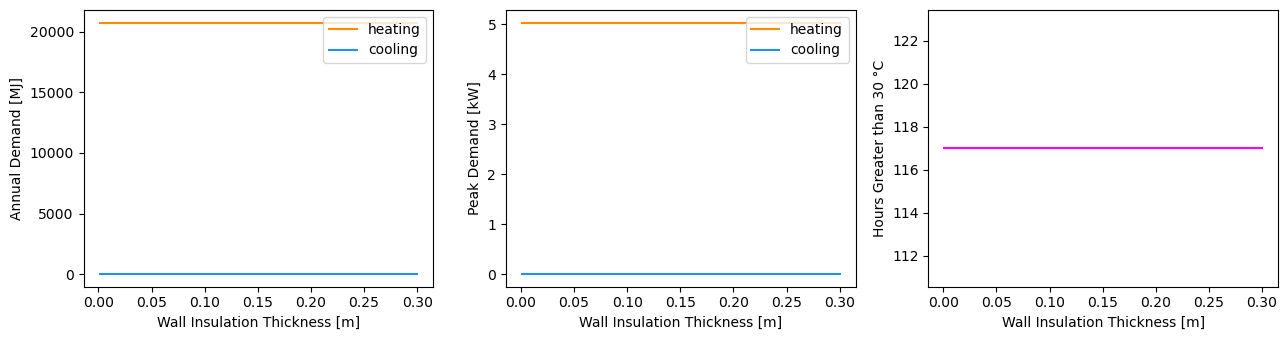

In [22]:
# Arrange multiple plots in one figure by using nrows and ncols arguments
fig, ax = plt.subplots(ncols = 3, nrows = 1)

# Plot the energy demand
ax[0].plot(df.wallInsulationThickness, df.heatingSum / 1.0E6, color = "darkorange", label = "heating")
ax[0].plot(df.wallInsulationThickness, df.coolingSum / 1.0E6, color = "dodgerblue", label = "cooling")

ax[0].set_xlabel("Wall Insulation Thickness [m]")
ax[0].set_ylabel("Annual Demand [MJ]")
ax[0].legend( loc = "upper right")

# Plot the peak loads
ax[1].plot(df.wallInsulationThickness, df.heatingMax / 1000, color = "darkorange", label = "heating")
ax[1].plot(df.wallInsulationThickness, df.coolingMax / 1000, color = "dodgerblue", label = "cooling")

ax[1].set_xlabel("Wall Insulation Thickness [m]")
ax[1].set_ylabel("Peak Demand [kW]")
ax[1].legend( loc = "upper right")

# Plot the overheating data
ax[2].plot(df.wallInsulationThickness, df["temperature>30C"], color = "magenta")

ax[2].set_xlabel("Wall Insulation Thickness [m]")
ax[2].set_ylabel("Hours Greater than 30 \N{DEGREE SIGN}C")

fig.set_figwidth(13)
fig.set_figheight(3.5)
fig.tight_layout()
plt.show()

<span style="color:orange; font-weight:bold;">Congratulations! You have just completed a parametric analysis.</span>

<span style ="color:lime;">You can continue to practice in the cells below:</span>
* <span style ="color:lime;">Repeat steps 4.2 to do a parametris analysis for window U-values (@u_windows@) and g-values (@g_value@).</span>

# 5. Tutorial 5 Summary

In this tutorial, you will have learned:
* How to perform a HDD linear regression analysis of energy bills
* How to perform calculations and simulations in parallel
* How to run EnergyPlus simulations using Python and automate changing parameters in parametric analysis
* How to collect and analysis EnergyPlus simulation results

In tutorial 6 and 7, we will build on these basics by getting EnergyPlus to run in parallel, and introducing multi-variable problem with thoughtful experimental design.